# CS294-112 Fall 2018 Tensorflow Tutorial

This tutorial will provide a brief overview of the core concepts and functionality of Tensorflow. This tutorial will cover the following:

0. What is Tensorflow
1. How to input data
2. How to perform computations
3. How to create variables
4. How to train a neural network for a simple regression problem
5. Tips and tricks

In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches

In [2]:
def tf_reset():
    try:
        sess.close()
    except:
        pass
    tf.reset_default_graph()
    return tf.Session()

# 0. What is Tensorflow

Tensorflow is a framework to define a series of computations. You define inputs, what operations should be performed, and then Tensorflow will compute the outputs for you.

Below is a simple high-level example:

In [3]:
# create the session you'll work in
# you can think of this as a "blank piece of paper" that you'll be writing math on
sess = tf_reset()

# define your inputs
a = tf.constant(1.0)
b = tf.constant(2.0)

# do some operations
c = a + b

# get the result
c_run = sess.run(c)

print('c = {0}'.format(c_run))

c = 3.0


# 1. How to input data

Tensorflow has multiple ways for you to input data. One way is to have the inputs be constants:

In [4]:
sess = tf_reset()

# define your inputs
a = tf.constant(1.0)
b = tf.constant(2.0)

# do some operations
c = a + b

# get the result
c_run = sess.run(c)

print('c = {0}'.format(c_run))

c = 3.0


However, having our inputs be constants is inflexible. We want to be able to change what data we input at runtime. We can do this using placeholders:

In [5]:
sess = tf_reset()

# define your inputs
a = tf.placeholder(dtype=tf.float32, shape=[1], name='a_placeholder')
b = tf.placeholder(dtype=tf.float32, shape=[1], name='b_placeholder')

# do some operations
c = a + b

# get the result
c0_run = sess.run(c, feed_dict={a: [1.0], b: [2.0]})
c1_run = sess.run(c, feed_dict={a: [2.0], b: [4.0]})

print('c0 = {0}'.format(c0_run))
print('c1 = {0}'.format(c1_run))

c0 = [3.]
c1 = [6.]


But what if we don't know the size of our input beforehand? One dimension of a tensor is allowed to be 'None', which means it can be variable sized:

In [6]:
sess = tf_reset()

# inputs
a = tf.placeholder(dtype=tf.float32, shape=[None], name='a_placeholder')
b = tf.placeholder(dtype=tf.float32, shape=[None], name='b_placeholder')

# do some operations
c = a + b

# get outputs
c0_run = sess.run(c, feed_dict={a: [1.0], b: [2.0]})
c1_run = sess.run(c, feed_dict={a: [1.0, 2.0], b: [2.0, 4.0]})

print(a)
print('a shape: {0}'.format(a.get_shape()))
print(b)
print('b shape: {0}'.format(b.get_shape()))
print('c0 = {0}'.format(c0_run))
print('c1 = {0}'.format(c1_run))

Tensor("a_placeholder:0", shape=(?,), dtype=float32)
a shape: (?,)
Tensor("b_placeholder:0", shape=(?,), dtype=float32)
b shape: (?,)
c0 = [3.]
c1 = [3. 6.]


# 2. How to perform computations

Now that we can input data, we want to perform useful computations on the data.

First, let's create some data to work with:

In [7]:
sess = tf_reset()

# inputs
a = tf.constant([[-1.], [-2.], [-3.]], dtype=tf.float32)
b = tf.constant([[1., 2., 3.]], dtype=tf.float32)

a_run, b_run = sess.run([a, b])
print('a:\n{0}'.format(a_run))
print('b:\n{0}'.format(b_run))

a:
[[-1.]
 [-2.]
 [-3.]]
b:
[[1. 2. 3.]]


We can do simple operations, such as addition:

In [8]:
c = b + b

c_run = sess.run(c)
print('b:\n{0}'.format(b_run))
print('c:\n{0}'.format(c_run))

b:
[[1. 2. 3.]]
c:
[[2. 4. 6.]]


Be careful about the dimensions of the tensors, some operations may work even when you think they shouldn't...

In [9]:
c = a + b

c_run = sess.run(c)
print('a:\n{0}'.format(a_run))
print('b:\n{0}'.format(b_run))
print('c:\n{0}'.format(c_run))

a:
[[-1.]
 [-2.]
 [-3.]]
b:
[[1. 2. 3.]]
c:
[[ 0.  1.  2.]
 [-1.  0.  1.]
 [-2. -1.  0.]]


Also, some operations may be different than what you expect:

In [10]:
c_elementwise = a * b
c_matmul = tf.matmul(b, a)

c_elementwise_run, c_matmul_run = sess.run([c_elementwise, c_matmul])
print('a:\n{0}'.format(a_run))
print('b:\n{0}'.format(b_run))
print('c_elementwise:\n{0}'.format(c_elementwise_run))
print('c_matmul: \n{0}'.format(c_matmul_run))

a:
[[-1.]
 [-2.]
 [-3.]]
b:
[[1. 2. 3.]]
c_elementwise:
[[-1. -2. -3.]
 [-2. -4. -6.]
 [-3. -6. -9.]]
c_matmul: 
[[-14.]]


Operations can be chained together:

In [11]:
# operations can be chained together
c0 = b + b
c1 = c0 + 1

c0_run, c1_run = sess.run([c0, c1])
print('b:\n{0}'.format(b_run))
print('c0:\n{0}'.format(c0_run))
print('c1:\n{0}'.format(c1_run))

b:
[[1. 2. 3.]]
c0:
[[2. 4. 6.]]
c1:
[[3. 5. 7.]]


Finally, Tensorflow has many useful built-in operations:

In [12]:
c = tf.reduce_mean(b)

c_run = sess.run(c)
print('b:\n{0}'.format(b_run))
print('c:\n{0}'.format(c_run))

b:
[[1. 2. 3.]]
c:
2.0


# 3. How to create variables

Now that we can input data and perform computations, we want some of these operations to involve variables that are free parameters, and can be trained using an optimizer (e.g., gradient descent).

First, let's create some data to work with:

In [13]:
sess = tf_reset()

# inputs
b = tf.constant([[1., 2., 3.]], dtype=tf.float32)

sess = tf.Session()

b_run = sess.run(b)
print('b:\n{0}'.format(b_run))

b:
[[1. 2. 3.]]


We'll now create a variable

In [14]:
var_init_value = [[2.0, 4.0, 6.0]]
var = tf.get_variable(name='myvar',
                      shape=[1, 3],
                      dtype=tf.float32,
                      initializer=tf.constant_initializer(var_init_value))

print(var)

<tf.Variable 'myvar:0' shape=(1, 3) dtype=float32_ref>


and check that it's been added to Tensorflow's variables list:

In [15]:
print(tf.global_variables())

[<tf.Variable 'myvar:0' shape=(1, 3) dtype=float32_ref>]


We can do operations with the variable just like any other tensor:

In [16]:
# can do operations
c = b + var
print(b)
print(var)
print(c)

Tensor("Const:0", shape=(1, 3), dtype=float32)
<tf.Variable 'myvar:0' shape=(1, 3) dtype=float32_ref>
Tensor("add:0", shape=(1, 3), dtype=float32)


Before we can run any of these operations, we must first initalize the variables

In [17]:
init_op = tf.global_variables_initializer()
sess.run(init_op)

and then we can run the operations just as we normally would.

In [18]:
c_run = sess.run(c)

print('b:\n{0}'.format(b_run))
print('var:\n{0}'.format(var_init_value))
print('c:\n{0}'.format(c_run))

b:
[[1. 2. 3.]]
var:
[[2.0, 4.0, 6.0]]
c:
[[3. 6. 9.]]


So far we haven't said yet how to optimize these variables. We'll cover that next in the context of an example.

# 4. How to train a neural network for a simple regression problem

We've discussed how to input data, perform operations, and create variables. We'll now show how to combine all of these---with some minor additions---to train a neural network on a simple regression problem.

First, we'll create data for a 1-dimensional regression problem:

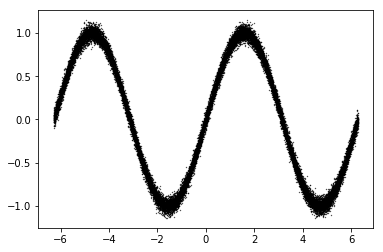

In [22]:
# generate the data
inputs = np.linspace(-2*np.pi, 2*np.pi, 10000)[:, None]
outputs = np.sin(inputs) + 0.05 * np.random.normal(size=[len(inputs),1])

plt.scatter(inputs[:, 0], outputs[:, 0], s=0.1, color='k', marker='o')
plt.show()

The below code creates the inputs, variables, neural network operations, mean-squared-error loss, gradient descent optimizer, and runs the optimizer using minibatches of the data.

In [23]:
sess = tf_reset()

def create_model():
    # create inputs
    input_ph = tf.placeholder(dtype=tf.float32, shape=[None, 1])
    output_ph = tf.placeholder(dtype=tf.float32, shape=[None, 1])

    # create variables
    W0 = tf.get_variable(name='W0', shape=[1, 20], initializer=tf.contrib.layers.xavier_initializer())
    W1 = tf.get_variable(name='W1', shape=[20, 20], initializer=tf.contrib.layers.xavier_initializer())
    W2 = tf.get_variable(name='W2', shape=[20, 1], initializer=tf.contrib.layers.xavier_initializer())

    b0 = tf.get_variable(name='b0', shape=[20], initializer=tf.constant_initializer(0.))
    b1 = tf.get_variable(name='b1', shape=[20], initializer=tf.constant_initializer(0.))
    b2 = tf.get_variable(name='b2', shape=[1], initializer=tf.constant_initializer(0.))

    weights = [W0, W1, W2]
    biases = [b0, b1, b2]
    activations = [tf.nn.relu, tf.nn.relu, None]

    # create computation graph
    layer = input_ph
    for W, b, activation in zip(weights, biases, activations):
        layer = tf.matmul(layer, W) + b
        if activation is not None:
            layer = activation(layer)
    output_pred = layer
    
    return input_ph, output_ph, output_pred
    
input_ph, output_ph, output_pred = create_model()
    
# create loss
mse = tf.reduce_mean(0.5 * tf.square(output_pred - output_ph))

# create optimizer
opt = tf.train.AdamOptimizer().minimize(mse)

# initialize variables
sess.run(tf.global_variables_initializer())
# create saver to save model variables
saver = tf.train.Saver()

# run training
batch_size = 32
for training_step in range(10000):
    # get a random subset of the training data
    indices = np.random.randint(low=0, high=len(inputs), size=batch_size)
    input_batch = inputs[indices]
    output_batch = outputs[indices]
    
    # run the optimizer and get the mse
    _, mse_run = sess.run([opt, mse], feed_dict={input_ph: input_batch, output_ph: output_batch})
    
    # print the mse every so often
    if training_step % 1000 == 0:
        print('{0:04d} mse: {1:.3f}'.format(training_step, mse_run))
        saver.save(sess, './model.ckpt')

0000 mse: 0.212
1000 mse: 0.060
2000 mse: 0.017
3000 mse: 0.014
4000 mse: 0.002
5000 mse: 0.002
6000 mse: 0.002
7000 mse: 0.001
8000 mse: 0.001
9000 mse: 0.001


Now that the neural network is trained, we can use it to make predictions:

INFO:tensorflow:Restoring parameters from ./model.ckpt


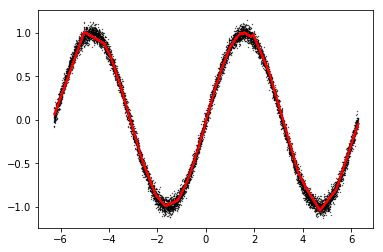

In [24]:
sess = tf_reset()

# create the model
input_ph, output_ph, output_pred = create_model()

# restore the saved model
saver = tf.train.Saver()
saver.restore(sess, "./model.ckpt")

output_pred_run = sess.run(output_pred, feed_dict={input_ph: inputs})

plt.scatter(inputs[:, 0], outputs[:, 0], c='k', marker='o', s=0.1)
plt.scatter(inputs[:, 0], output_pred_run[:, 0], c='r', marker='o', s=0.1)
plt.show()

Not so hard after all! There is much more functionality to Tensorflow besides what we've covered, but you now know the basics.

# 5. Tips and tricks

##### (a) Check your dimensions

In [27]:
# example of "surprising" resulting dimensions due to broadcasting
a = tf.constant(np.random.random((4, 1)))
b = tf.constant(np.random.random((1, 4)))
c = a * b
assert c.get_shape() == (4, 4)

##### (b) Check what variables have been created

In [28]:
sess = tf_reset()
a = tf.get_variable('I_am_a_variable', shape=[4, 6])
b = tf.get_variable('I_am_a_variable_too', shape=[2, 7])
for var in tf.global_variables():
    print(var.name)

I_am_a_variable:0
I_am_a_variable_too:0


##### (c) Look at the [tensorflow API](https://www.tensorflow.org/api_docs/python/), or open up a python terminal and investigate!

In [29]:
help(tf.reduce_mean)

Help on function reduce_mean in module tensorflow.python.ops.math_ops:

reduce_mean(input_tensor, axis=None, keepdims=None, name=None, reduction_indices=None, keep_dims=None)
    Computes the mean of elements across dimensions of a tensor. (deprecated arguments)
    
    SOME ARGUMENTS ARE DEPRECATED. They will be removed in a future version.
    Instructions for updating:
    keep_dims is deprecated, use keepdims instead
    
    Reduces `input_tensor` along the dimensions given in `axis`.
    Unless `keepdims` is true, the rank of the tensor is reduced by 1 for each
    entry in `axis`. If `keepdims` is true, the reduced dimensions
    are retained with length 1.
    
    If `axis` is None, all dimensions are reduced, and a
    tensor with a single element is returned.
    
    For example:
    
    ```python
    x = tf.constant([[1., 1.], [2., 2.]])
    tf.reduce_mean(x)  # 1.5
    tf.reduce_mean(x, 0)  # [1.5, 1.5]
    tf.reduce_mean(x, 1)  # [1.,  2.]
    ```
    
    Args:
      

##### (d) Tensorflow has some built-in layers to simplify your code.

In [30]:
help(tf.contrib.layers.fully_connected)

Help on function fully_connected in module tensorflow.contrib.layers.python.layers.layers:

fully_connected(inputs, num_outputs, activation_fn=<function relu at 0x0000024FB5A329D8>, normalizer_fn=None, normalizer_params=None, weights_initializer=<function variance_scaling_initializer.<locals>._initializer at 0x0000024FB79060D0>, weights_regularizer=None, biases_initializer=<tensorflow.python.ops.init_ops.Zeros object at 0x0000024FB7900B70>, biases_regularizer=None, reuse=None, variables_collections=None, outputs_collections=None, trainable=True, scope=None)
    Adds a fully connected layer.
    
    `fully_connected` creates a variable called `weights`, representing a fully
    connected weight matrix, which is multiplied by the `inputs` to produce a
    `Tensor` of hidden units. If a `normalizer_fn` is provided (such as
    `batch_norm`), it is then applied. Otherwise, if `normalizer_fn` is
    None and a `biases_initializer` is provided then a `biases` variable would be
    created a

##### (e) Use [variable scope](https://www.tensorflow.org/guide/variables#sharing_variables) to keep your variables organized.

In [31]:
sess = tf_reset()

# create variables
with tf.variable_scope('layer_0'):
    W0 = tf.get_variable(name='W0', shape=[1, 20], initializer=tf.contrib.layers.xavier_initializer())
    b0 = tf.get_variable(name='b0', shape=[20], initializer=tf.constant_initializer(0.))

with tf.variable_scope('layer_1'):
    W1 = tf.get_variable(name='W1', shape=[20, 20], initializer=tf.contrib.layers.xavier_initializer())
    b1 = tf.get_variable(name='b1', shape=[20], initializer=tf.constant_initializer(0.))
    
with tf.variable_scope('layer_2'):
    W2 = tf.get_variable(name='W2', shape=[20, 1], initializer=tf.contrib.layers.xavier_initializer())
    b2 = tf.get_variable(name='b2', shape=[1], initializer=tf.constant_initializer(0.))

# print the variables
var_names = sorted([v.name for v in tf.global_variables()])
print('\n'.join(var_names))

layer_0/W0:0
layer_0/b0:0
layer_1/W1:0
layer_1/b1:0
layer_2/W2:0
layer_2/b2:0


##### (f) You can specify which GPU you want to use and how much memory you want to use

In [27]:
gpu_device = 0
gpu_frac = 0.5

# make only one of the GPUs visible
import os
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_device)

# only use part of the GPU memory
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_frac)
config = tf.ConfigProto(gpu_options=gpu_options)

# create the session
tf_sess = tf.Session(graph=tf.Graph(), config=config)

##### (g) You can use [tensorboard](https://www.tensorflow.org/guide/summaries_and_tensorboard) to visualize and monitor the training process.